In [363]:
import pandas as pd 
import os
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import glob
import tensorflow as tf
from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter
import pydot
import cv2
import imutils

In [364]:
dataDir=Path('./tsu_ai_m2_dataset/')
annFile = Path('./tsu_ai_m2_dataset/result.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [365]:
for img in imgs:
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    if len(anns) > 0:
        mask = coco.annToMask(anns[0])
        for i in range(1, len(anns)):
            mask += coco.annToMask(anns[i])
        im = Image.fromarray(mask)
        im.save('./tsu_ai_m2_dataset/masks/' + str(img['file_name'][9:][:-4]) + '_' + str(img['id']) + '.png')

C:\Users\fklas\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


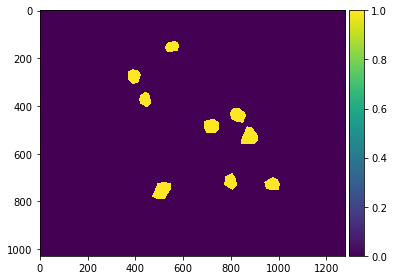

In [366]:
img = imgs[50]
annIds = coco.getAnnIds(imgIds=[img['id']])
anns = coco.loadAnns(annIds)
if len(anns) > 0:
    mask = coco.annToMask(anns[0])
    for i in range(1, len(anns)):
        mask += coco.annToMask(anns[i])
    im = Image.fromarray(mask)
imshow(np.array(im))
im.save('./tsu_ai_m2_dataset/masks/' + str(img['file_name'][9:][:-4]) + '_' + str(img['id']) + '.png')

In [367]:
CLASSES = 1

COLORS = ['orange']

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (1280, 1028)

In [368]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.4, 0.9)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [369]:
# images = sorted(glob.glob('tsu_ai_m2_dataset/images/9/*.jpg'))[:284]
images = sorted(['tsu_ai_m2_dataset/images/9/' + img['file_name'][9:] for img in imgs])
masks = sorted(glob.glob('tsu_ai_m2_dataset/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(5)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

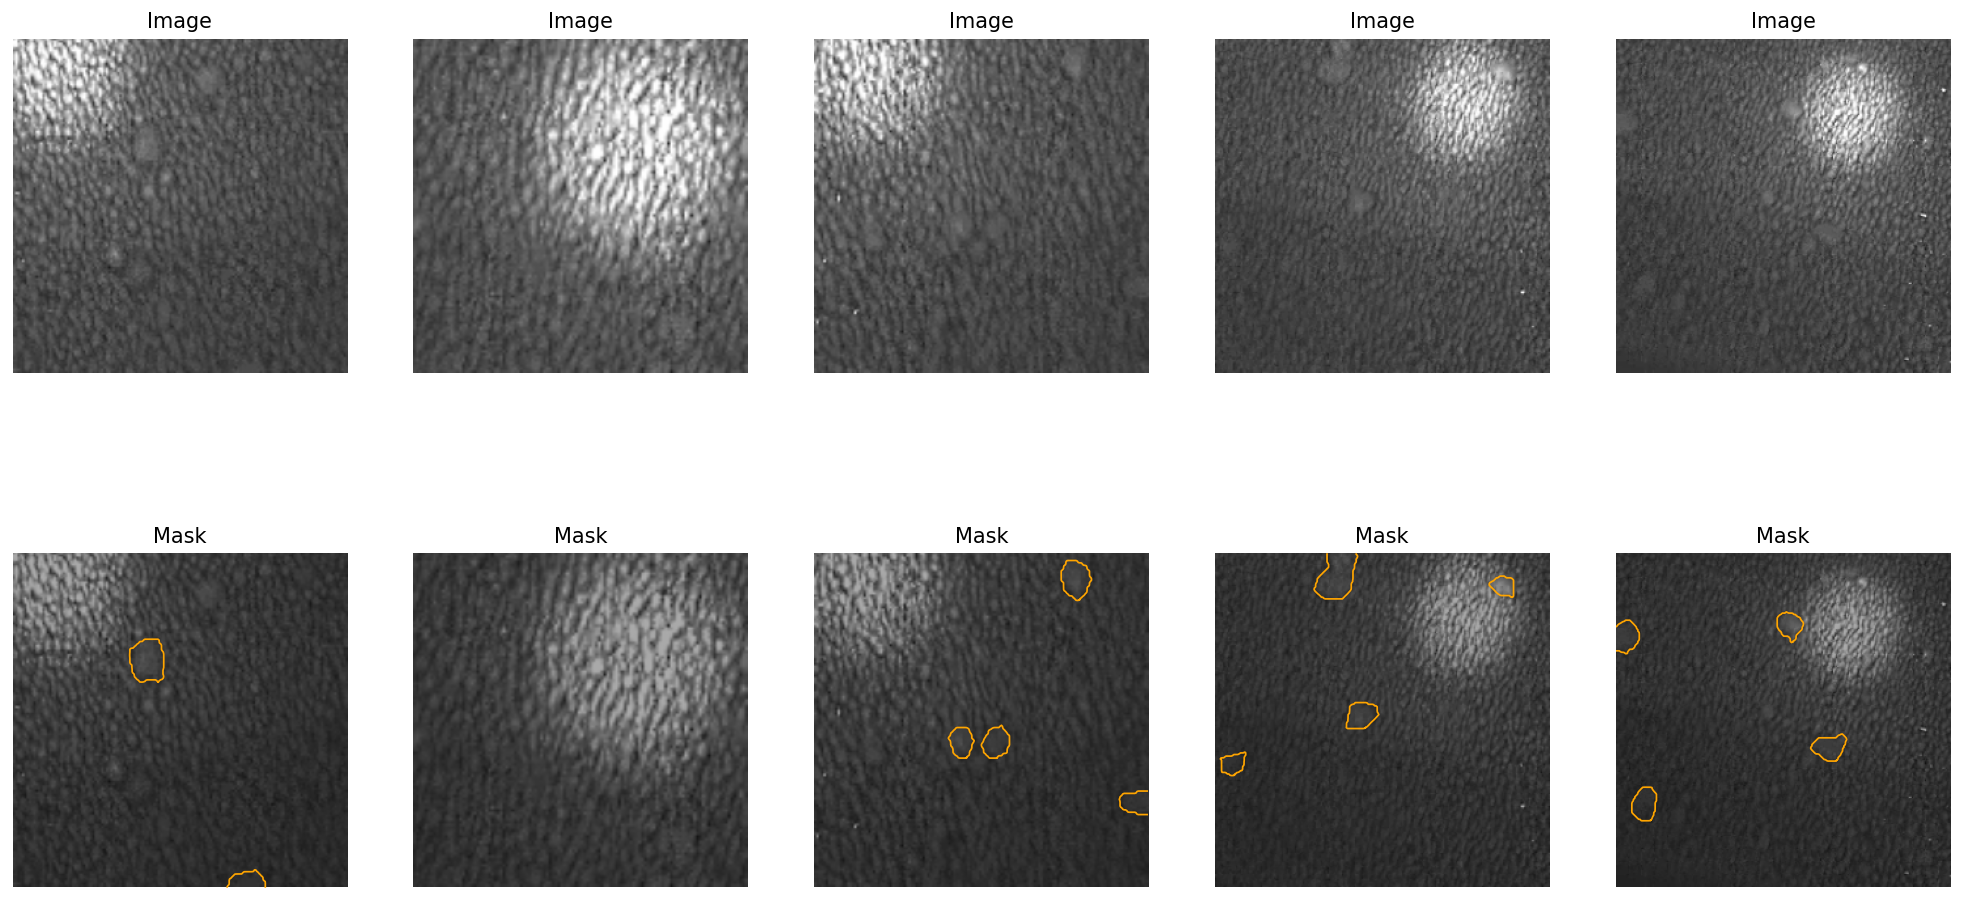

In [370]:
images_and_masks = list(dataset.skip(200).take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image / 1.5)
    
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [371]:
train_dataset = dataset.take(1000).cache()
test_dataset = dataset.skip(1000).take(350).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

In [372]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

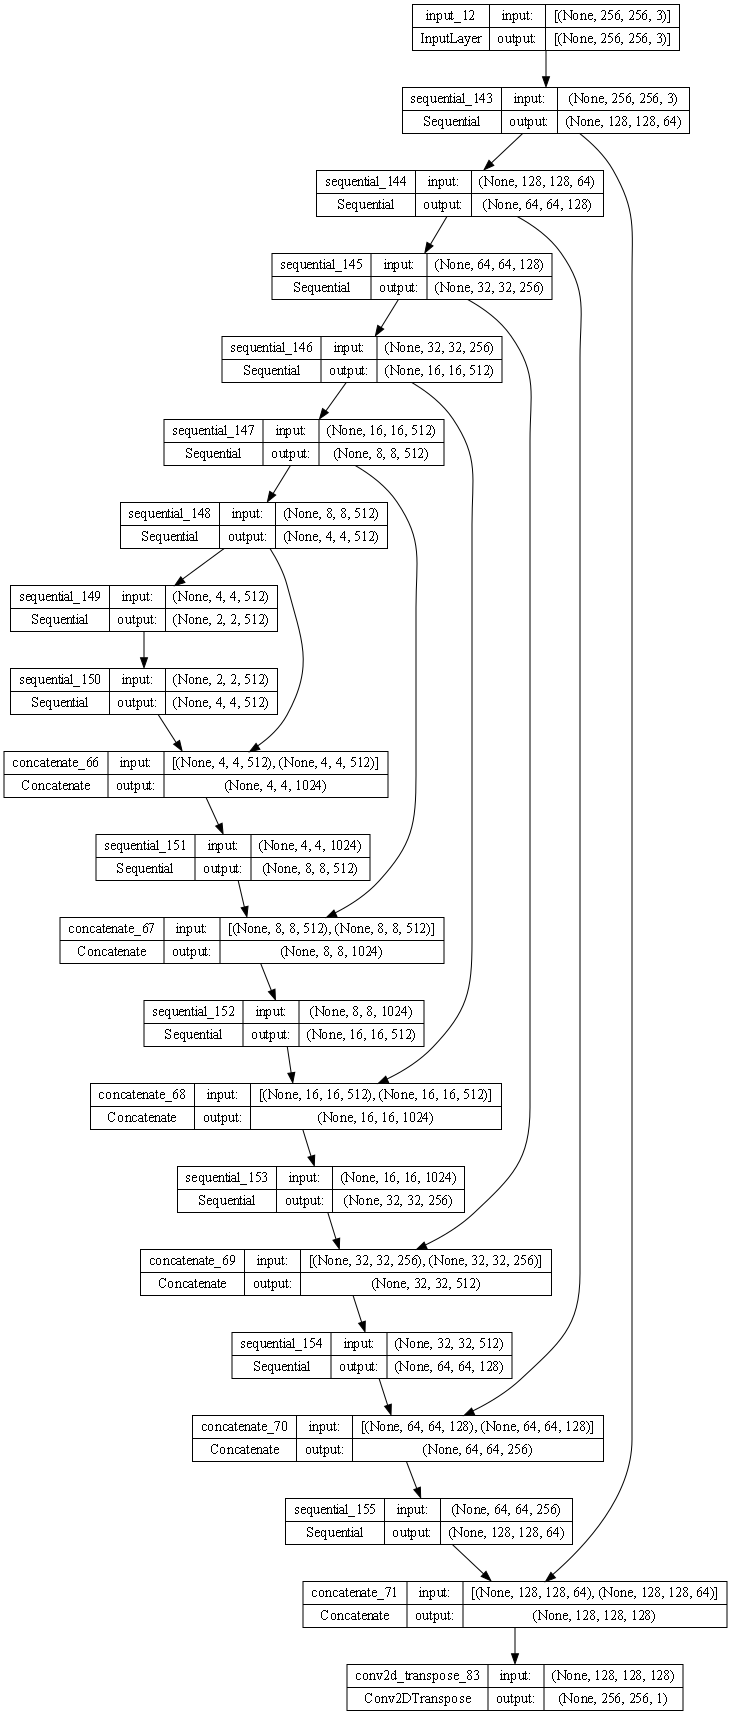

In [373]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

In [374]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [375]:
SMOOTH = 1e-6
# tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def iou(outputs, labels):
    outputs = tf.cast(tf.round(outputs), 'int32')
    labels = tf.cast(tf.round(labels), 'int32')
    outputs = tf.squeeze(outputs, axis=3)
    labels = tf.squeeze(labels, axis=3)

    intersection = tf.math.reduce_sum((outputs & labels), (1, 2))
    union = tf.math.reduce_sum((outputs | labels), (1, 2))
    iou = intersection / union

    return iou

In [376]:
unet_like.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou, dice_mc_metric])

In [377]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=5, initial_epoch=0)

unet_like.save_weights('SemanticSegmentationLesson/networks/unet_like_aug_v2')

Epoch 1/5
125/125 [==============================] - 414s 3s/step - loss: 0.1046 - iou: 0.9771 - dice_mc_metric: 0.9661 - val_loss: 0.1046 - val_iou: 0.9808 - val_dice_mc_metric: 0.9880
Epoch 2/5
125/125 [==============================] - 311s 2s/step - loss: 0.0487 - iou: 0.9833 - dice_mc_metric: 0.9862 - val_loss: 0.0785 - val_iou: 0.9808 - val_dice_mc_metric: 0.9862
Epoch 3/5
125/125 [==============================] - 305s 2s/step - loss: 0.0346 - iou: 0.9883 - dice_mc_metric: 0.9900 - val_loss: 0.0527 - val_iou: 0.9846 - val_dice_mc_metric: 0.9854
Epoch 4/5
125/125 [==============================] - 305s 2s/step - loss: 0.0304 - iou: 0.9892 - dice_mc_metric: 0.9913 - val_loss: 0.0633 - val_iou: 0.9827 - val_dice_mc_metric: 0.9888
Epoch 5/5
125/125 [==============================] - 320s 3s/step - loss: 0.0276 - iou: 0.9900 - dice_mc_metric: 0.9920 - val_loss: 0.0451 - val_iou: 0.9848 - val_dice_mc_metric: 0.9892


In [378]:
unet_like.load_weights('SemanticSegmentationLesson/networks/unet_like_aug_v2')

In [319]:
frames = sorted(glob.glob('tsu_ai_m2_dataset/images/*.jpg'))
filename = frames[10]
frame = imread(filename)
sample = resize(frame, SAMPLE_SIZE)

predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
# predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

1/1 [==============================] - 0s 177ms/step


C:\Users\fklas\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


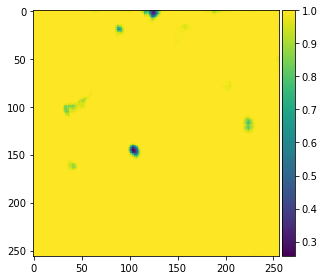

In [320]:
imshow(predict.squeeze()[:, :])

In [138]:
from tqdm import tqdm
rgb_colors = [
    (255, 255, 255)
]

frames = sorted(glob.glob('tsu_ai_m2_dataset/images/*.jpg'))

for filename in tqdm(frames):
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(0, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        for contour in contours:
            rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                       contour[:, 1] * scale[1],
                                       shape=contour_overlay.shape)

            contour_overlay[rr, cc] = 1 

        contour_overlay = dilation(contour_overlay, disk(1))
        frame[contour_overlay == 1] = rgb_colors[channel]

    imsave(f'tsu_ai_m2_dataset/test/{os.path.basename(filename)[9:]}', frame)

  0%|                                                                                          | 0/284 [00:00<?, ?it/s]

1/1 [==============================] - 0s 265ms/step


  0%|                                                                                          | 0/284 [00:00<?, ?it/s]


IndexError: list index out of range

In [166]:
unet_like.load_weights('SemanticSegmentationLesson/networks/unet_like_aug')

In [249]:
rgb_colors = [
    (255, 255, 255),
    (255, 99, 71)
]

In [334]:
def frame_to_mask(frame):
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(0, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        biggest_area = 0
        for contour in contours:
            c = np.expand_dims(contour.astype(np.float32), 1)
            c = cv2.UMat(c)
            area = cv2.contourArea(c)
            
            if area > biggest_area:
                biggest_area = area

            rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                       contour[:, 1] * scale[1],
                                       shape=contour_overlay.shape)
            if area >= 100:
                contour_overlay[rr, cc] = 1 

        contour_overlay = dilation(contour_overlay, disk(1))
        frame[contour_overlay == 1] = rgb_colors[channel]
        
        for contour in contours:
            c = np.expand_dims(contour.astype(np.float32), 1)
            c = cv2.UMat(c)
            area = cv2.contourArea(c)
            
            if area == biggest_area:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 2 
        
        contour_overlay = dilation(contour_overlay, disk(1))
        frame[contour_overlay == 2] = rgb_colors[1]
    
    return frame

In [335]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0, prod=False):
    print(1, brightness, contrast)
    brightness = map(brightness, 0, 510, -255, 255)
    contrast = map(contrast, 0, 254, -127, 127)
    print(2, brightness, contrast)
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
        
    if prod==False:
        cv2.putText(buf,'B:{},C:{}'.format(brightness,contrast),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return buf

def map(x, in_min, in_max, out_min, out_max):
    return int((x-in_min) * (out_max-out_min) / (in_max-in_min) + out_min)

In [336]:
cap = cv2.VideoCapture(r'./tsu_ai_m2_dataset/clodding_train.avi')

if not cap.isOpened():
    print("Error opening video stream or file")

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        
        brightness = 100
        contrast = 65
        frame = apply_brightness_contrast(frame, 100 + 255, 65 + 127, prod=False)
        
        frame = imutils.resize(frame, width=700)
        frame = frame_to_mask(frame)
        cv2.imshow('Frame', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
            
        if cv2.waitKey(1) & 0xFF == ord('p'):
            time.sleep(5)

    else:
        break

cap.release()
cv2.destroyAllWindows()

1 355 192
2 100 65
1/1 [==============================] - 0s 131ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 135ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 134ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 148ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 143ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 143ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 125ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 132ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 158ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 146ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 144ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 144ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 143ms/step
1 355 192
2 100 65
1/1 [==============================] - 0s 155

In [379]:
res = unet_like.evaluate(train_dataset.take(10))
res

10/10 [==============================] - 8s 752ms/step - loss: 0.0471 - iou: 0.9841 - dice_mc_metric: 0.9891


[0.04711935669183731, 0.9841105341911316, 0.9890886545181274]